<a href="https://colab.research.google.com/github/yc7415/gachon-ml-2025/blob/main/%EA%B3%BC%EC%A0%9C1_202337641_%EA%B9%80%EC%9A%A9%EC%B0%AC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) 공공데이터 또는 100건 이상의 데이터


In [ ]:

# 0) 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import joblib

plt.rcParams['figure.figsize'] = (8,4)



## 실데이터 경로 지정



In [ ]:

csv_path = "/content/kbo_team_stats_real.csv"

df_raw = pd.read_csv(csv_path)

korean_map = {
    "year":"연도", "team":"팀", "G":"경기",
    "R":"득점", "H":"안타", "HR":"홈런", "RA":"실점",
    "BB":"볼넷", "SO":"삼진", "E":"실책", "W":"승", "L":"패",
}
df_raw = df_raw.rename(columns={k:v for k,v in korean_map.items() if k in df_raw.columns})

print("통일 후 컬럼:", df_raw.columns.tolist())
display(df_raw.head())



통일 후 컬럼: ['연도', '팀', '경기', '득점', '안타', '홈런', '실점']


,연도,팀,경기,득점,안타,홈런,실점
0,2013,LG,136,752,1297,124,533
1,2013,롯데,135,632,1244,68,687
2,2013,한화,136,662,1236,114,518
3,2013,삼성,135,704,1222,149,604
4,2013,두산,135,606,1218,96,644


In [ ]:
# === Colab 한 셀 실행용: 설치 + 크롤링(타자+투수만) + CSV 저장 ===
!pip install -q requests beautifulsoup4 lxml

import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO

# -------- 설정 --------
START_YEAR = 2013
END_YEAR   = 2024
OUT_CSV    = "/content/kbo_team_stats_real.csv"  # 저장 경로(Colab)

HITTER_URL  = "https://www.koreabaseball.com/Record/Team/Hitter/Basic1.aspx"
PITCHER_URL = "https://www.koreabaseball.com/Record/Team/Pitcher/Basic1.aspx"

headers = {"User-Agent": "Mozilla/5.0"}

def fetch_table(url, year):
    params = {"season": year}
    res = requests.get(url, params=params, headers=headers, timeout=20)
    res.raise_for_status()
    soup = BeautifulSoup(res.text, "lxml")
    table = soup.find("table")
    if table is None:
        raise RuntimeError(f"표를 찾지 못했습니다: {url} {year}")
    # FutureWarning 회피: StringIO 감싸기
    df_list = pd.read_html(StringIO(str(table)))
    return df_list[0]

def pick_first(df, candidates):
    """candidates 리스트 중 존재하는 첫 컬럼명을 반환 (없으면 None)"""
    for c in candidates:
        if c in df.columns:
            return c
    return None

all_rows = []

for year in range(START_YEAR, END_YEAR + 1):
    print(f"Fetching data for {year}...")
    # 1) 타자 팀 기록
    hit = fetch_table(HITTER_URL, year)
    hit = hit.rename(columns=lambda c: str(c).strip())
    # 합계 제거
    if "팀명" in hit.columns:
        hit = hit[~hit["팀명"].astype(str).str.contains("합계")]
    elif "팀" in hit.columns:
        hit = hit[~hit["팀"].astype(str).str.contains("합계")]

    # 주요 컬럼 찾기
    col_team = pick_first(hit, ["팀명","팀","Team"])
    col_g    = pick_first(hit, ["G","경기"])
    col_r    = pick_first(hit, ["R","득점"])
    col_h    = pick_first(hit, ["H","안타"])
    col_hr   = pick_first(hit, ["HR","홈런"])
    col_bb   = pick_first(hit, ["BB","볼넷"])
    col_so   = pick_first(hit, ["SO","삼진"])

    keep_map = {"팀": col_team, "경기": col_g, "득점": col_r, "안타": col_h, "홈런": col_hr}
    if col_bb: keep_map["볼넷"] = col_bb
    if col_so: keep_map["삼진"] = col_so

    hit = hit[list(keep_map.values())].copy()
    hit.columns = list(keep_map.keys())

    # 2) 투수 팀 기록 (실점 R)
    pit = fetch_table(PITCHER_URL, year)
    pit = pit.rename(columns=lambda c: str(c).strip())
    if "팀명" in pit.columns:
        pit = pit[~pit["팀명"].astype(str).str.contains("합계")]
    elif "팀" in pit.columns:
        pit = pit[~pit["팀"].astype(str).str.contains("합계")]

    col_team_p = pick_first(pit, ["팀명","팀","Team"])
    col_ra     = pick_first(pit, ["R","실점"])
    pit = pit[[col_team_p, col_ra]].copy()
    pit.columns = ["팀", "실점"]

    # 3) 병합
    df = pd.merge(hit, pit, on="팀", how="inner")
    df.insert(0, "연도", year)
    all_rows.append(df)

    time.sleep(0.6)

# 전체 합치기
full = pd.concat(all_rows, ignore_index=True)

# 타입 정리
for c in ["경기","득점","안타","홈런","볼넷","삼진","실점"]:
    if c in full.columns:
        full[c] = pd.to_numeric(full[c], errors="coerce")

full.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("저장 완료:", OUT_CSV)
display(full.head())
print("총 행:", len(full))
print("최종 컬럼:", full.columns.tolist())


Fetching data for 2013...
Fetching data for 2014...
Fetching data for 2015...
Fetching data for 2016...
Fetching data for 2017...
Fetching data for 2018...
Fetching data for 2019...
Fetching data for 2020...
Fetching data for 2021...
Fetching data for 2022...
Fetching data for 2023...
Fetching data for 2024...
저장 완료: /content/kbo_team_stats_real.csv


,연도,팀,경기,득점,안타,홈런,실점
0,2013,LG,136,752,1297,124,533
1,2013,롯데,135,632,1244,68,687
2,2013,한화,136,662,1236,114,518
3,2013,삼성,135,704,1222,149,604
4,2013,두산,135,606,1218,96,644


총 행: 120
최종 컬럼: ['연도', '팀', '경기', '득점', '안타', '홈런', '실점']


### 2) 데이터 전처리진행
- **승률**: `승 / (승 + 패)`  
- **득실점차**: `득점 - 실점`  
- **피타고리안 기대승률**: `득점^2 / (득점^2 + 실점^2)`  
- **경기당 지표**: 득점/경기, 안타/경기, 홈런/경기, 볼넷/경기, 삼진/경기, 실책/경기


In [ ]:
# ==== 전처리 핫픽스: W/L 없을 때 pyth_exp로 타깃 대체 & 필수 컬럼 완화 ====
# 여기서 df 는 앞 셀에서 auto_map_columns() 이후 만든 DataFrame 이어야 합니다.

import numpy as np
import pandas as pd

# ✅ df가 영문 컬럼이면 한글로 즉시 변환 (가드 코드)
if {"R","RA","H","HR"} <= set(df.columns) and "득점" not in df.columns:
    df = df.rename(columns={
        "year":"연도", "team":"팀", "G":"경기",
        "R":"득점", "H":"안타", "HR":"홈런", "RA":"실점",
        "BB":"볼넷", "SO":"삼진", "E":"실책", "W":"승", "L":"패",
    })

# 1) 필수/선택 컬럼 정의 (우리 CSV에 맞춰 최소화)
must_have = {"R":"득점", "RA":"실점", "H":"안타", "HR":"홈런"}
optional  = {"BB":"볼넷", "SO":"삼진", "E":"실책", "G":"경기"}

# 2) 존재하는 컬럼만 남기고 이름 표준화
rename_map = {}
missing_now = []
for std, alias_kr in must_have.items():
    if alias_kr in df.columns:
        rename_map[alias_kr] = std
    else:
        missing_now.append(alias_kr)

if missing_now:
    raise ValueError(f"필수 컬럼이 부족합니다(득점/실점/안타/홈런 중 누락): {missing_now}\n현재 컬럼: {df.columns.tolist()}")

for std, alias_kr in optional.items():
    if alias_kr in df.columns:
        rename_map[alias_kr] = std

df = df.rename(columns=rename_map)

# 3) 타깃 결정: W/L 있으면 실제 승률, 없으면 pyth_exp (득점^2 / (득점^2+실점^2))
if "W" in df.columns and "L" in df.columns:
    df["승률"] = df["W"] / (df["W"] + df["L"])
    target_used = "actual_winpct"
else:
    df["pyth_exp"] = (df["R"]**2) / ( (df["R"]**2) + (df["RA"]**2) )
    df["승률"] = df["pyth_exp"]
    target_used = "pyth_exp (대체 타깃)"

# 4) 파생변수(있으면 활용)
if "G" not in df.columns:
    # 경기 수가 없으면 승/패 합 또는 144로 채우기
    if {"W","L"} <= set(df.columns):
        df["G"] = (df["W"] + df["L"]).replace(0, np.nan)
    else:
        df["G"] = 144

df["득실점차"] = df["R"] - df["RA"]
for col in ["R","H","HR"] + [c for c in ["BB","SO","E"] if c in df.columns]:
    df[f"{col}_perG"] = df[col] / df["G"].replace(0, np.nan)

# 5) 타깃/피처 분리
y = df["승률"]
drop_cols = ["승률","team","팀","연도","year","pyth_exp"]  # 설명용/식별자/중복 타깃 컬럼 제거
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

print(f"[INFO] 타깃 사용: {target_used}")
print("X 컬럼:", X.columns.tolist())
print("데이터 크기:", X.shape, y.shape)


[INFO] 타깃 사용: pyth_exp (대체 타깃)
X 컬럼: ['G', 'R', 'H', 'HR', 'RA', '득실점차', 'R_perG', 'H_perG', 'HR_perG']
데이터 크기: (120, 9) (120,)


In [ ]:
# ==== 한글 컬럼용 빠른 전처리 (df_raw -> df, X, y) ====
import numpy as np
import pandas as pd

df = df_raw.copy()

# 필요한 컬럼 확인
needed = ["연도","팀","경기","득점","안타","홈런","실점"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"CSV에 필요한 기본 컬럼이 없습니다: {missing}\n현재 컬럼: {df.columns.tolist()}")

# 타깃: 피타고리안 기대승률 (승/패 데이터가 없으므로 대체)
df["승률"] = (df["득점"]**2) / ((df["득점"]**2) + (df["실점"]**2))

# 파생 변수
df["득실점차"] = df["득점"] - df["실점"]
df["득점_perG"] = df["득점"] / df["경기"].replace(0, np.nan)
df["안타_perG"] = df["안타"] / df["경기"].replace(0, np.nan)
df["홈런_perG"] = df["홈런"] / df["경기"].replace(0, np.nan)

# X, y 분리
feature_cols = ["경기","득점","안타","홈런","실점","득실점차",
                "득점_perG","안타_perG","홈런_perG"]
X = df[feature_cols].copy()
y = df["승률"]

# 정리
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

print("[INFO] 타깃 = 승률 (피타고리안 기대승률)")
print("X shape / y shape:", X.shape, y.shape)
print("X columns:", X.columns.tolist())


[INFO] 타깃 = 승률 (피타고리안 기대승률)
X shape / y shape: (120, 9) (120,)
X columns: ['경기', '득점', '안타', '홈런', '실점', '득실점차', '득점_perG', '안타_perG', '홈런_perG']



## 3)  학습 알고리즘 선택 후 학습
- 1. hold-out(8:2분할)
  2. KFold(5-Fold 교차검증)
  3. 최종 학습 & 홀드아웃 테스트 평가


,모델,MAE,MSE,RMSE,R²
0,LinearRegression,0.002809,0.000011,0.003285,0.998810
1,Ridge,0.003314,0.000017,0.004097,0.998149
2,Lasso,0.003749,0.000020,0.004450,0.997816


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


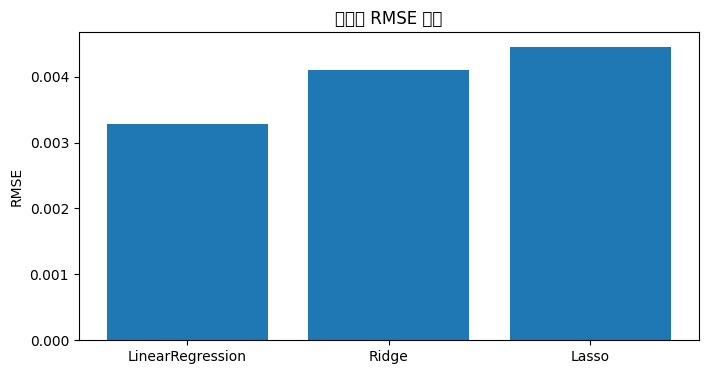

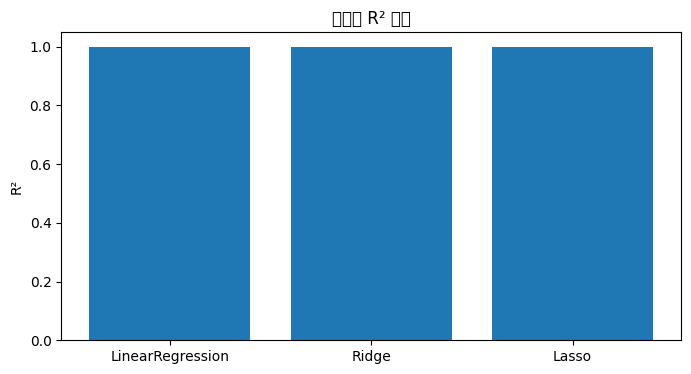

In [ ]:
# ③ 학습(Linear/Ridge/Lasso) + ④ 성능지표 표/그래프
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 스케일링(수치형 전체에 적용)
num_cols = X_train.columns.tolist()
preproc = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="drop")

models = {
    "LinearRegression": Pipeline([("prep", preproc), ("model", LinearRegression())]),
    "Ridge":           Pipeline([("prep", preproc), ("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso":           Pipeline([("prep", preproc), ("model", Lasso(alpha=0.001, random_state=42, max_iter=10000))]),
}

results = []
preds_dict = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds_dict[name] = y_pred

    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)

    results.append({"모델": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2})

score_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True)
display(score_df)

# ④ 성능 시각화
plt.figure(figsize=(8,4))
plt.bar(score_df["모델"], score_df["RMSE"])
plt.title("모델별 RMSE 비교")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(score_df["모델"], score_df["R²"])
plt.title("모델별 R² 비교")
plt.ylabel("R²")
plt.show()



## 5) *알고리즘 선정 이유*
Linear Regression: 선형 관계의 베이스라인 모델로 해석 용이, 계수 기반 영향 분석 가능

Ridge (L2): 과적합 완화, 다중공선성 상황에서 계수 안정성 향상

Lasso (L1): 불필요 특성의 계수를 0으로 수축해 변수 선택 효과 제공

## 6) *지표 선정 이유*

MAE: 평균 절대오차 — 오차 크기를 직관적으로 파악

MSE / RMSE: 큰 오차에 더 민감 — 모델 안정성과 전반적 성능 비교에 유리

R²: 설명력 — 1에 가까울수록 예측이 잘 맞음


## 7) *테스트 데이터 예측*


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

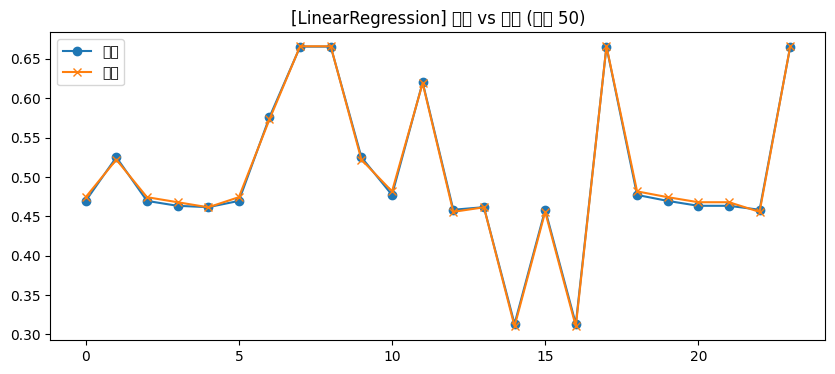

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


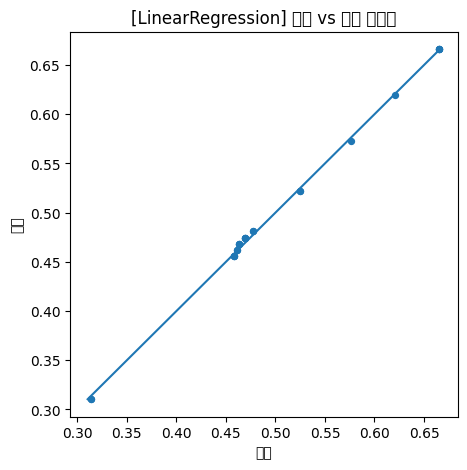

In [ ]:
# ⑤ 테스트 데이터 예측: 실제 vs 예측 (가장 성능 좋은 모델 기준)
best_model_name = score_df.iloc[0]["모델"]
best_pred = preds_dict[best_model_name]

# 표본 50개 라인 플롯
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:50], label="실제", marker="o")
plt.plot(best_pred[:50], label="예측", marker="x")
plt.title(f"[{best_model_name}] 실제 vs 예측 (샘플 50)")
plt.legend()
plt.show()

# 산점도(전체): y=x에 가까울수록 좋음
plt.figure(figsize=(5,5))
plt.scatter(y_test, best_pred, s=18)
minv = min(y_test.min(), best_pred.min())
maxv = max(y_test.max(), best_pred.max())
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("실제")
plt.ylabel("예측")
plt.title(f"[{best_model_name}] 실제 vs 예측 산점도")
plt.show()



## 8) (보너스) 모델 저장/불러오기
파이프라인(스케일러 + 모델)을 통째로 저장합니다.


In [ ]:
import joblib

best_pipe = models[best_model_name]
joblib.dump(best_pipe, "best_model_kbo_winrate_pipeline.pkl")

loaded = joblib.load("best_model_kbo_winrate_pipeline.pkl")
print("로드 확인:", loaded.predict(X_test[:3]))


로드 확인: [0.47436795 0.52210151 0.47436795]
